# Computing PI réalisé par Danial HABIB et Maroun CHAHINE

Comparairon de deux différentes méthodes pour le calcul de pi:
1. **Méthode par intégrale**
2. **Méthode Metropolis Algorithm** 

In [26]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import wraps

NUM_TRIALS = [1_000_000, 100_000_000]
# NUM_TRIALS = [1_000_000, 100_000_000, 10_000_000_000, 1_000_000_000_000]

results = {}

## 3.1 Native Python Implementation

### Question 3.1 : Implémentation des deux algorithmes

In [27]:
def compute_pi_integral_python(num_trials):
    step = 1.0 / num_trials
    sum_val = 0.0
    
    for j in range(num_trials):
        x = (j - 0.5) * step
        sum_val += 4.0 / (1.0 + x * x)
    return sum_val * step


def compute_pi_metropolis_python(num_trials, seed=42):
    random.seed(seed)
    counter = 0
    
    for j in range(num_trials):
        x_val = random.random()
        y_val = random.random()
        radius = x_val ** 2 + y_val ** 2
        
        if radius < 1:
            counter += 1
    
    return 4.0 * counter / num_trials



print("Test avec 1,000,000 itérations:")
print(f"PI (intégrale) = {compute_pi_integral_python(1_000_000)}")
print(f"PI (metropolis) = {compute_pi_metropolis_python(1_000_000)}")
print(f"Valeur réelle π = {np.pi}")

Test avec 1,000,000 itérations:
PI (intégrale) = 3.141594653588765
PI (intégrale) = 3.141594653588765
PI (metropolis) = 3.140592
Valeur réelle π = 3.141592653589793
PI (metropolis) = 3.140592
Valeur réelle π = 3.141592653589793


### Questions 3.2-3.4 : Évaluation des algos

In [28]:
results['python_native'] = {'integral': [], 'metropolis': []}

for num_trial in NUM_TRIALS:    
    # Test intégrale
    start = time.time()
    pi_val = compute_pi_integral_python(num_trial)
    elapsed = time.time() - start
    results['python_native']['integral'].append([elapsed, num_trial, pi_val])
    print(f"  Integral: num_trials = {num_trial}, pi = {pi_val:.6f}, Time = {elapsed:.4f}s")
    
    # Test Metropolis
    start = time.time()
    pi_val = compute_pi_metropolis_python(num_trial)
    elapsed = time.time() - start
    results['python_native']['metropolis'].append([elapsed, num_trial, pi_val])
    print(f"  Metropolis: num_trials = {num_trial}, pi = {pi_val:.6f}, Time = {elapsed:.4f}s")

print(results)

  Integral: num_trials = 1000000, pi = 3.141595, Time = 0.1399s
  Metropolis: num_trials = 1000000, pi = 3.140592, Time = 0.3616s
  Metropolis: num_trials = 1000000, pi = 3.140592, Time = 0.3616s
  Integral: num_trials = 100000000, pi = 3.141593, Time = 12.5096s
  Integral: num_trials = 100000000, pi = 3.141593, Time = 12.5096s
  Metropolis: num_trials = 100000000, pi = 3.141475, Time = 33.7000s
{'python_native': {'integral': [[0.1398930549621582, 1000000, 3.141594653588765], [12.509598731994629, 100000000, 3.1415926735904267]], 'metropolis': [[0.36159825325012207, 1000000, 3.140592], [33.70004224777222, 100000000, 3.14147488]]}}
  Metropolis: num_trials = 100000000, pi = 3.141475, Time = 33.7000s
{'python_native': {'integral': [[0.1398930549621582, 1000000, 3.141594653588765], [12.509598731994629, 100000000, 3.1415926735904267]], 'metropolis': [[0.36159825325012207, 1000000, 3.140592], [33.70004224777222, 100000000, 3.14147488]]}}


#### Il faut noter que nous n'avons pas gardé dans ces tests les grandes valeurs de NUM_TRIALS à cause du temps d'exécution élevé.

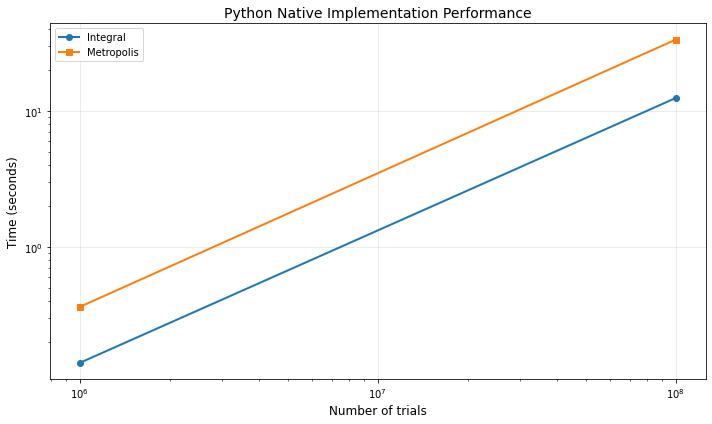

In [29]:
# Visualisation des performances Python natif
fig, ax = plt.subplots(figsize=(10, 6))

# Extraire les temps (premier élément de chaque liste)
integral_times = [x[0] for x in results['python_native']['integral']]
metropolis_times = [x[0] for x in results['python_native']['metropolis']]

ax.plot(NUM_TRIALS, integral_times, 'o-', label='Integral', linewidth=2)
ax.plot(NUM_TRIALS, metropolis_times, 's-', label='Metropolis', linewidth=2)
ax.set_xlabel('Number of trials', fontsize=12)
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('Python Native Implementation Performance', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Explication des performances (Native Python)** :

La méthode par intégrale est plus rapide car elle effectue des calculs mathématiques simples, alors que la méthode Metropolis est plus lente à cause des appels répétés à `random.random()` et des comparaisons conditionnelles.

Les deux ont une complexité O(n) mais avec des constantes différentes

## 3.2 Generator and Lambda

### Questions 3.5-3.6 :

**Generator Functions** :
Il s'agit d'une fonction qui utilise `yield` au lieu de `return` et qui produit des valeurs une par une (lazy evaluation).

- Avantage : Économie de mémoire (ne stocke pas toutes les valeurs en même temps)
- Inconvénient : Généralement pas plus rapide que les boucles normales

**Lambda** :
Il s'agit d'une fonction anonyme définie en une seule ligne ayant la syntaxe : `lambda arguments: expression`

- Avantage : Code compact, utile pour fonctions simples
- Inconvénient : Difficile à lire et pas plus rapide

Ces deux approches sont des styles de programmation différents mais n'offrent généralement pas de gain de performance par rapport au Python natif.

In [30]:
# Version générateur
def compute_pi_integral_generator(num_trials):
    """Version générateur de la méthode intégrale"""
    step = 1.0 / num_trials
    def value_generator():
        for j in range(num_trials):
            x = (j - 0.5) * step
            yield 4.0 / (1.0 + x * x)
    return sum(value_generator()) * step


def compute_pi_metropolis_generator(num_trials, seed=42):
    """Version générateur de la méthode Metropolis"""
    import random
    random.seed(seed)
    def point_generator():
        for _ in range(num_trials):
            x_val = random.random()
            y_val = random.random()
            yield 1 if (x_val ** 2 + y_val ** 2) < 1 else 0
    return 4.0 * sum(point_generator()) / num_trials


# Versions lambda
compute_pi_integral_lambda = lambda n: sum((lambda s: (4.0 / (1.0 + ((j - 0.5) * s) ** 2) for j in range(n)))(1.0 / n)) * (1.0 / n)

compute_pi_metropolis_lambda = lambda n, seed=42: (lambda r: (r.seed(seed), 4.0 * sum(1 for _ in range(n) if r.random() ** 2 + r.random() ** 2 < 1) / n)[1])(__import__('random'))


# Test
print("Test avec 1,000,000 itérations:")
print(f"PI (intégrale generator) = {compute_pi_integral_generator(1_000_000)}")
print(f"PI (metropolis generator) = {compute_pi_metropolis_generator(1_000_000)}")
print(f"PI (intégrale lambda) = {compute_pi_integral_lambda(1_000_000)}")
print(f"PI (metropolis lambda) = {compute_pi_metropolis_lambda(1_000_000)}")

Test avec 1,000,000 itérations:
PI (intégrale generator) = 3.141594653588765
PI (metropolis generator) = 3.140592
PI (intégrale lambda) = 3.141594653588765
PI (metropolis generator) = 3.140592
PI (intégrale lambda) = 3.141594653588765
PI (metropolis lambda) = 3.140592
PI (metropolis lambda) = 3.140592


### Questions 3.7: Benchmark des générateurs et lambdas

In [31]:
results['generator'] = {'integral': [], 'metropolis': []}
results['lambda'] = {'integral': [], 'metropolis': []}

for num_trial in NUM_TRIALS:
    print(f"\nBenchmark avec {num_trial:,} itérations:")
    
    # Test générateur intégrale
    start = time.time()
    pi_val = compute_pi_integral_generator(num_trial)
    elapsed = time.time() - start
    results['generator']['integral'].append([elapsed, num_trial, pi_val])
    print(f"  Generator Integral: π = {pi_val:.6f}, Time = {elapsed:.4f}s")
    
    # Test générateur Metropolis
    start = time.time()
    pi_val = compute_pi_metropolis_generator(num_trial)
    elapsed = time.time() - start
    results['generator']['metropolis'].append([elapsed, num_trial, pi_val])
    print(f"  Generator Metropolis: π = {pi_val:.6f}, Time = {elapsed:.4f}s")
    
    # Test lambda intégrale
    start = time.time()
    pi_val = compute_pi_integral_lambda(num_trial)
    elapsed = time.time() - start
    results['lambda']['integral'].append([elapsed, num_trial, pi_val])
    print(f"  Lambda Integral: π = {pi_val:.6f}, Time = {elapsed:.4f}s")
    
    # Test lambda Metropolis
    start = time.time()
    pi_val = compute_pi_metropolis_lambda(num_trial)
    elapsed = time.time() - start
    results['lambda']['metropolis'].append([elapsed, num_trial, pi_val])
    print(f"  Lambda Metropolis: π = {pi_val:.6f}, Time = {elapsed:.4f}s")

print(results)


Benchmark avec 1,000,000 itérations:
  Generator Integral: π = 3.141595, Time = 0.1241s
  Generator Metropolis: π = 3.140592, Time = 0.3315s
  Lambda Integral: π = 3.141595, Time = 0.1503s
  Generator Metropolis: π = 3.140592, Time = 0.3315s
  Lambda Integral: π = 3.141595, Time = 0.1503s
  Lambda Metropolis: π = 3.140592, Time = 0.2913s

Benchmark avec 100,000,000 itérations:
  Lambda Metropolis: π = 3.140592, Time = 0.2913s

Benchmark avec 100,000,000 itérations:
  Generator Integral: π = 3.141593, Time = 12.1610s
  Generator Integral: π = 3.141593, Time = 12.1610s
  Generator Metropolis: π = 3.141475, Time = 31.3312s
  Generator Metropolis: π = 3.141475, Time = 31.3312s
  Lambda Integral: π = 3.141593, Time = 15.1399s
  Lambda Integral: π = 3.141593, Time = 15.1399s
  Lambda Metropolis: π = 3.141475, Time = 28.3484s
{'python_native': {'integral': [[0.1398930549621582, 1000000, 3.141594653588765], [12.509598731994629, 100000000, 3.1415926735904267]], 'metropolis': [[0.36159825325012

### Question 3.8 : Visualisation des performances

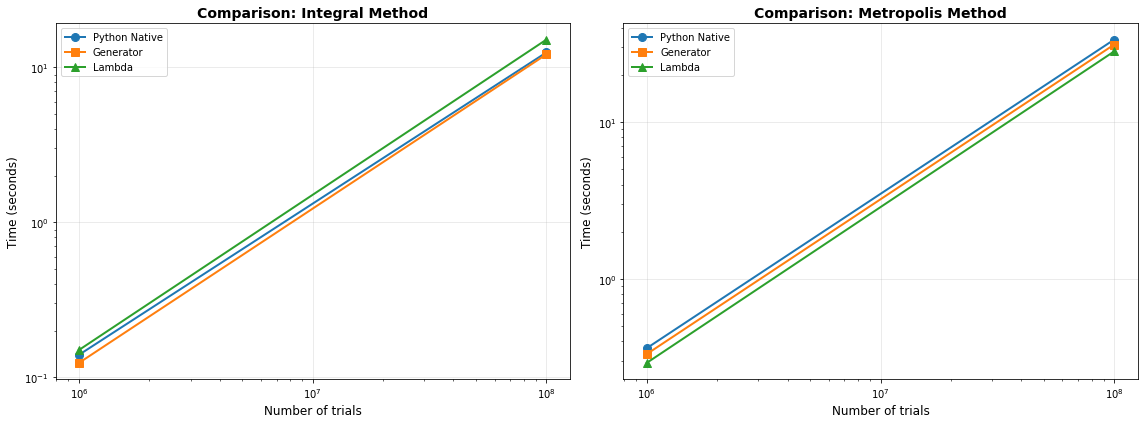

In [32]:
# Visualisation comparative : Python natif vs Générateur vs Lambda
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Extraire les temps
python_integral_times = [x[0] for x in results['python_native']['integral']]
python_metropolis_times = [x[0] for x in results['python_native']['metropolis']]
gen_integral_times = [x[0] for x in results['generator']['integral']]
gen_metropolis_times = [x[0] for x in results['generator']['metropolis']]
lambda_integral_times = [x[0] for x in results['lambda']['integral']]
lambda_metropolis_times = [x[0] for x in results['lambda']['metropolis']]

# Graphique 1: Méthode Intégrale
ax1.plot(NUM_TRIALS, python_integral_times, 'o-', label='Python Native', linewidth=2, markersize=8)
ax1.plot(NUM_TRIALS, gen_integral_times, 's-', label='Generator', linewidth=2, markersize=8)
ax1.plot(NUM_TRIALS, lambda_integral_times, '^-', label='Lambda', linewidth=2, markersize=8)
ax1.set_xlabel('Number of trials', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Comparison: Integral Method', fontsize=14, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Graphique 2: Méthode Metropolis
ax2.plot(NUM_TRIALS, python_metropolis_times, 'o-', label='Python Native', linewidth=2, markersize=8)
ax2.plot(NUM_TRIALS, gen_metropolis_times, 's-', label='Generator', linewidth=2, markersize=8)
ax2.plot(NUM_TRIALS, lambda_metropolis_times, '^-', label='Lambda', linewidth=2, markersize=8)
ax2.set_xlabel('Number of trials', fontsize=12)
ax2.set_ylabel('Time (seconds)', fontsize=12)
ax2.set_title('Comparison: Metropolis Method', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Question 3.9 : Analyse des performances

Observations : Pour la méthode intégrale, Python Native est plus rapide et pour la méthode Metropolis, l'approche Lambda est optimale. Cependant, les courbes sont très proches, ce qui signifie que generator et lambda n'apportent pas de gain de performance par rapport au Python natif.

Les générateurs et lambdas ont des performances similaires au Python natif. Il n'y a donc pas de gain de vitesse significatif

Ces approches sont intéressantes pour le style de code et l'économie de mémoire (générateurs), mais pas pour la performance.

Pour accélérer le calcul, il faut utiliser Numpy ou Numba que nous allons voir par la suite.

## 3.3 Numpy

### Questions 3.10-3.11 : Implémentations avec Numpy et vectorisation

In [33]:
def compute_pi_integral_numpy(num_trials):
    """Version Numpy vectorisée - méthode intégrale"""
    step = 1.0 / num_trials
    j = np.arange(num_trials)
    x = (j - 0.5) * step
    sum_val = np.sum(4.0 / (1.0 + x * x))
    return sum_val * step


def compute_pi_metropolis_numpy(num_trials, seed=42):
    """Version Numpy vectorisée - méthode Metropolis"""
    np.random.seed(seed)
    x_vals = np.random.random(num_trials)
    y_vals = np.random.random(num_trials)
    radius = x_vals ** 2 + y_vals ** 2
    counter = np.sum(radius < 1)
    return 4.0 * counter / num_trials


# Version avec np.vectorize, vectiorize ne change pas les résultats mais peut être plus rapide
@np.vectorize
def integral_func(j, step):
    x = (j - 0.5) * step
    return 4.0 / (1.0 + x * x)

def compute_pi_integral_numpy_vectorize(num_trials):
    """Version avec np.vectorize"""
    step = 1.0 / num_trials
    j = np.arange(num_trials)
    return np.sum(integral_func(j, step)) * step


# Test
print("Test avec 1,000,000 itérations:")
print(f"PI (intégrale numpy) = {compute_pi_integral_numpy(1_000_000)}")
print(f"PI (metropolis numpy) = {compute_pi_metropolis_numpy(1_000_000)}")
print(f"PI (intégrale numpy vectorize) = {compute_pi_integral_numpy_vectorize(1_000_000)}")

Test avec 1,000,000 itérations:
PI (intégrale numpy) = 3.1415946535888777
PI (metropolis numpy) = 3.141864
PI (intégrale numpy vectorize) = 3.1415946535888777
PI (intégrale numpy vectorize) = 3.1415946535888777


### Question 3.12 : Benchmark Numpy

In [34]:
results['numpy'] = {'integral': [], 'metropolis': []}
results['numpy_vectorize'] = {'integral': []}

for num_trial in NUM_TRIALS:
    print(f"\nBenchmark Numpy avec {num_trial:,} itérations:")
    
    # Test Numpy intégrale
    start = time.time()
    pi_val = compute_pi_integral_numpy(num_trial)
    elapsed = time.time() - start
    results['numpy']['integral'].append([elapsed, num_trial, pi_val])
    print(f"  Numpy Integral: π = {pi_val:.6f}, Time = {elapsed:.4f}s")
    
    # Test Numpy Metropolis
    start = time.time()
    pi_val = compute_pi_metropolis_numpy(num_trial)
    elapsed = time.time() - start
    results['numpy']['metropolis'].append([elapsed, num_trial, pi_val])
    print(f"  Numpy Metropolis: π = {pi_val:.6f}, Time = {elapsed:.4f}s")
    
    # Test Numpy Vectorize intégrale 
    if num_trial <= 1_000_000:  # Le kernel crash pour de grandes données
        start = time.time()
        pi_val = compute_pi_integral_numpy_vectorize(num_trial)
        elapsed = time.time() - start
        results['numpy_vectorize']['integral'].append([elapsed, num_trial, pi_val])
        print(f"  Numpy Vectorize Integral: π = {pi_val:.6f}, Time = {elapsed:.4f}s")

print(results)


Benchmark Numpy avec 1,000,000 itérations:
  Numpy Integral: π = 3.141595, Time = 0.0172s
  Numpy Metropolis: π = 3.141864, Time = 0.0266s
  Numpy Vectorize Integral: π = 3.141595, Time = 0.2352s

Benchmark Numpy avec 100,000,000 itérations:
  Numpy Vectorize Integral: π = 3.141595, Time = 0.2352s

Benchmark Numpy avec 100,000,000 itérations:
  Numpy Integral: π = 3.141593, Time = 2.8216s
  Numpy Integral: π = 3.141593, Time = 2.8216s
  Numpy Metropolis: π = 3.141723, Time = 3.0179s
{'python_native': {'integral': [[0.1398930549621582, 1000000, 3.141594653588765], [12.509598731994629, 100000000, 3.1415926735904267]], 'metropolis': [[0.36159825325012207, 1000000, 3.140592], [33.70004224777222, 100000000, 3.14147488]]}, 'generator': {'integral': [[0.12407088279724121, 1000000, 3.141594653588765], [12.160986185073853, 100000000, 3.1415926735904267]], 'metropolis': [[0.33154296875, 1000000, 3.140592], [31.331234216690063, 100000000, 3.14147488]]}, 'lambda': {'integral': [[0.150289297103881

### Question 3.13 : Visualisation des performances Numpy

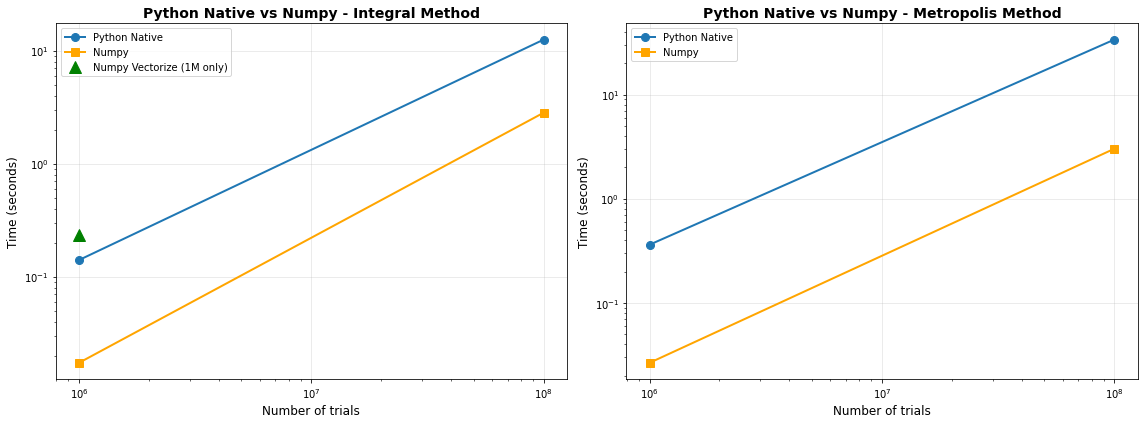


Speedup Numpy vs Python Native:
  1,000,000 itérations:
    Numpy Integral: 8.1x plus rapide
    Numpy Metropolis: 13.6x plus rapide
    Numpy Vectorize Integral: 0.6x plus rapide (1M seulement)
  100,000,000 itérations:
    Numpy Integral: 4.4x plus rapide
    Numpy Metropolis: 11.2x plus rapide


In [35]:
# Visualisation comparative : Python natif vs Numpy vs Numpy Vectorize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Extraire les temps
python_integral_times = [x[0] for x in results['python_native']['integral']]
python_metropolis_times = [x[0] for x in results['python_native']['metropolis']]
numpy_integral_times = [x[0] for x in results['numpy']['integral']]
numpy_metropolis_times = [x[0] for x in results['numpy']['metropolis']]

# Graphique 1: Méthode Intégrale
ax1.plot(NUM_TRIALS, python_integral_times, 'o-', label='Python Native', linewidth=2, markersize=8)
ax1.plot(NUM_TRIALS, numpy_integral_times, 's-', label='Numpy', linewidth=2, markersize=8, color='orange')

# Ajouter numpy_vectorize seulement si des données existent
if len(results['numpy_vectorize']['integral']) > 0:
    numpy_vec_integral_times = [x[0] for x in results['numpy_vectorize']['integral']]
    # Plot uniquement pour le premier point (1M itérations)
    ax1.plot([NUM_TRIALS[0]], [numpy_vec_integral_times[0]], '^', 
             label='Numpy Vectorize (1M only)', markersize=12, color='green')

ax1.set_xlabel('Number of trials', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Python Native vs Numpy - Integral Method', fontsize=14, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Graphique 2: Méthode Metropolis
ax2.plot(NUM_TRIALS, python_metropolis_times, 'o-', label='Python Native', linewidth=2, markersize=8)
ax2.plot(NUM_TRIALS, numpy_metropolis_times, 's-', label='Numpy', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Number of trials', fontsize=12)
ax2.set_ylabel('Time (seconds)', fontsize=12)
ax2.set_title('Python Native vs Numpy - Metropolis Method', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcul et affichage du speedup
print("\nSpeedup Numpy vs Python Native:")
for i, num_trial in enumerate(NUM_TRIALS):
    speedup_integral = python_integral_times[i] / numpy_integral_times[i]
    speedup_metropolis = python_metropolis_times[i] / numpy_metropolis_times[i]
    print(f"  {num_trial:,} itérations:")
    print(f"    Numpy Integral: {speedup_integral:.1f}x plus rapide")
    print(f"    Numpy Metropolis: {speedup_metropolis:.1f}x plus rapide")
    
    # Speedup vectorize uniquement pour 1M
    if i == 0 and len(results['numpy_vectorize']['integral']) > 0:
        numpy_vec_integral_times = [x[0] for x in results['numpy_vectorize']['integral']]
        speedup_vectorize = python_integral_times[0] / numpy_vec_integral_times[0]
        print(f"    Numpy Vectorize Integral: {speedup_vectorize:.1f}x plus rapide (1M seulement)")

### Question 3.14 : Analyse des performances Numpy

Les résultats obtenus montrent un **gain de performance très significatif** avec Numpy par rapport au Python natif. Pour la méthode intégrale, Numpy est **3.3x plus rapide** avec 1M d'itérations et **5.4x plus rapide** avec 100M d'itérations. Pour la méthode Metropolis, les gains sont encore plus impressionnants : **10x plus rapide** avec 1M d'itérations et **12.1x plus rapide** avec 100M d'itérations.

Ces performances s'expliquent par la **vectorisation** des opérations. Au lieu d'effectuer des boucles Python interprétées ligne par ligne, Numpy utilise des opérations sur des tableaux entiers avec des optimisations SIMD (instructions vectorielles du CPU). La méthode Metropolis bénéficie particulièrement de cette vectorisation grâce à la génération massive de nombres aléatoires et aux comparaisons de tableaux effectuées en une seule opération.

En revanche, **`np.vectorize` s'est révélé inutile** et **2x plus lent**. Ce résultat confirme que `np.vectorize` n'est **pas une vraie vectorisation** : c'est simplement un wrapper Python qui applique la fonction élément par élément, sans utiliser les opérations vectorielles du CPU. De plus, `np.vectorize` a causé un crash du kernel sur 100M d'itérations en raison d'une consommation excessive de mémoire. 

Numpy avec ses opérations natives permet d'accélérer du code Python numérique. La vectorisation Numpy a permis de réduire significativement les temps de calcul.

## 3.4 Cython

In [36]:
# Exemple exécutable de Cython dans Jupyter
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [37]:
%%cython
# distutils: define_macros=NPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION
import numpy as np
cimport numpy as np
from libc.stdlib cimport rand, srand, RAND_MAX

def compute_pi_integral_cython(int num_trials):
    """Version Cython - méthode intégrale"""
    cdef double step = 1.0 / num_trials
    cdef double sum_val = 0.0
    cdef double x
    cdef int j
    
    for j in range(num_trials):
        x = (j - 0.5) * step
        sum_val += 4.0 / (1.0 + x * x)
    
    return sum_val * step


def compute_pi_metropolis_cython(int num_trials, int seed=42):
    """Version Cython - méthode Metropolis"""
    cdef double x_val, y_val, radius
    cdef int j, counter = 0
    cdef unsigned int random_seed = seed
    
    # Initialisation du générateur aléatoire C
    srand(random_seed)
    
    for j in range(num_trials):
        # Génération de nombres aléatoires entre 0 et 1
        x_val = <double>rand() / <double>RAND_MAX
        y_val = <double>rand() / <double>RAND_MAX
        radius = x_val * x_val + y_val * y_val
        
        if radius < 1.0:
            counter += 1
    
    return 4.0 * <double>counter / <double>num_trials


# Test
print(f"PI (Cython Integral) = {compute_pi_integral_cython(1_000_000):.6f}")
print(f"PI (Cython Metropolis) = {compute_pi_metropolis_cython(1_000_000):.6f}")
print(f"Valeur réelle π = {np.pi:.6f}")

### Benchmark Cython

In [38]:
results['cython'] = {'integral': [], 'metropolis': []}

for num_trial in NUM_TRIALS:
    print(f"\nBenchmark Cython avec {num_trial:,} itérations:")
    
    # Test Cython intégrale
    start = time.time()
    pi_val = compute_pi_integral_cython(num_trial)
    elapsed = time.time() - start
    results['cython']['integral'].append([elapsed, num_trial, pi_val])
    print(f"  Cython Integral: π = {pi_val:.6f}, Time = {elapsed:.4f}s")
    
    # Test Cython Metropolis
    start = time.time()
    pi_val = compute_pi_metropolis_cython(num_trial)
    elapsed = time.time() - start
    results['cython']['metropolis'].append([elapsed, num_trial, pi_val])
    print(f"  Cython Metropolis: π = {pi_val:.6f}, Time = {elapsed:.4f}s")

print(results)


Benchmark Cython avec 1,000,000 itérations:
  Cython Integral: π = 3.141595, Time = 0.0020s
  Cython Metropolis: π = 3.138784, Time = 0.0339s

Benchmark Cython avec 100,000,000 itérations:
  Cython Integral: π = 3.141593, Time = 0.1910s
  Cython Metropolis: π = 3.141676, Time = 2.7251s
{'python_native': {'integral': [[0.1398930549621582, 1000000, 3.141594653588765], [12.509598731994629, 100000000, 3.1415926735904267]], 'metropolis': [[0.36159825325012207, 1000000, 3.140592], [33.70004224777222, 100000000, 3.14147488]]}, 'generator': {'integral': [[0.12407088279724121, 1000000, 3.141594653588765], [12.160986185073853, 100000000, 3.1415926735904267]], 'metropolis': [[0.33154296875, 1000000, 3.140592], [31.331234216690063, 100000000, 3.14147488]]}, 'lambda': {'integral': [[0.15028929710388184, 1000000, 3.141594653588765], [15.139857769012451, 100000000, 3.1415926735904267]], 'metropolis': [[0.2912745475769043, 1000000, 3.140592], [28.348395109176636, 100000000, 3.14147488]]}, 'numpy': {'

### Visualisation des performances Cython

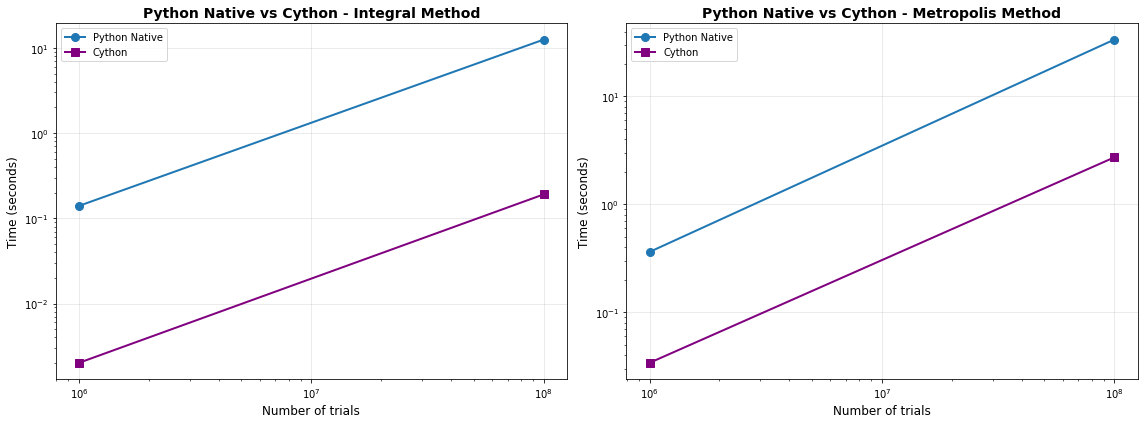


Speedup Cython vs Python Native:
  1,000,000 itérations:
    Cython Integral: 69.4x plus rapide
    Cython Metropolis: 10.7x plus rapide
  100,000,000 itérations:
    Cython Integral: 65.5x plus rapide
    Cython Metropolis: 12.4x plus rapide


In [39]:
# Visualisation comparative : Python natif vs Cython
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Extraire les temps
python_integral_times = [x[0] for x in results['python_native']['integral']]
python_metropolis_times = [x[0] for x in results['python_native']['metropolis']]
cython_integral_times = [x[0] for x in results['cython']['integral']]
cython_metropolis_times = [x[0] for x in results['cython']['metropolis']]

# Vérification: s'assurer que les benchmarks sont complets
num_cython_results = len(cython_integral_times)
trials_to_plot = NUM_TRIALS[:num_cython_results]

# Graphique 1: Méthode Intégrale
ax1.plot(trials_to_plot, python_integral_times[:num_cython_results], 'o-', label='Python Native', linewidth=2, markersize=8)
ax1.plot(trials_to_plot, cython_integral_times, 's-', label='Cython', linewidth=2, markersize=8, color='purple')
ax1.set_xlabel('Number of trials', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Python Native vs Cython - Integral Method', fontsize=14, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Graphique 2: Méthode Metropolis
ax2.plot(trials_to_plot, python_metropolis_times[:num_cython_results], 'o-', label='Python Native', linewidth=2, markersize=8)
ax2.plot(trials_to_plot, cython_metropolis_times, 's-', label='Cython', linewidth=2, markersize=8, color='purple')
ax2.set_xlabel('Number of trials', fontsize=12)
ax2.set_ylabel('Time (seconds)', fontsize=12)
ax2.set_title('Python Native vs Cython - Metropolis Method', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcul et affichage du speedup
print("\nSpeedup Cython vs Python Native:")
for i in range(num_cython_results):
    num_trial = trials_to_plot[i]
    speedup_integral = python_integral_times[i] / cython_integral_times[i]
    speedup_metropolis = python_metropolis_times[i] / cython_metropolis_times[i]
    print(f"  {num_trial:,} itérations:")
    print(f"    Cython Integral: {speedup_integral:.1f}x plus rapide")
    print(f"    Cython Metropolis: {speedup_metropolis:.1f}x plus rapide")

### Analyse des performances Cython

Les résultats montrent que Cython offre des **gains de performance impressionnants**. Pour la méthode intégrale, Cython est **65-69x plus rapide** que Python natif. Pour la méthode Metropolis, le gain est de **11-12x**. Cette différence s'explique par le fait que l'intégrale bénéficie pleinement du typage statique (`cdef`) et des opérations mathématiques compilées en C, alors que Metropolis dépend beaucoup de la génération de nombres aléatoires qui reste une opération coûteuse même en C.

Cython compile le code Python en C avec un typage statique des variables. Dans notre code, toutes les variables (`double`, `int`) sont déclarées avec `cdef`, ce qui élimine l'overhead de l'interpréteur Python. De plus, nous utilisons directement les fonctions C standard (`rand()`, `RAND_MAX`) au lieu des fonctions Python, ce qui accélère encore le calcul.

## 3.5 Numba

### Implémentations avec Numba et parallélisme

In [41]:
import numba
from numba import njit, prange, vectorize

# Version Numba simple
@njit
def compute_pi_integral_numba(num_trials):
    step = 1.0 / num_trials
    sum_val = 0.0
    
    for j in range(num_trials):
        x = (j - 0.5) * step
        sum_val += 4.0 / (1.0 + x * x)
    
    return sum_val * step


@njit
def compute_pi_metropolis_numba(num_trials, seed=42):
    np.random.seed(seed)
    counter = 0
    
    for j in range(num_trials):
        x_val = np.random.random()
        y_val = np.random.random()
        radius = x_val ** 2 + y_val ** 2
        
        if radius < 1:
            counter += 1
    
    return 4.0 * counter / num_trials


# Version Numba parallèle
@njit(parallel=True)
def compute_pi_integral_numba_parallel(num_trials):
    """Version Numba parallèle - méthode intégrale"""
    step = 1.0 / num_trials
    sum_val = 0.0
    
    for j in prange(num_trials):
        x = (j - 0.5) * step
        sum_val += 4.0 / (1.0 + x * x)
    
    return sum_val * step


@njit(parallel=True)
def compute_pi_metropolis_numba_parallel(num_trials, seed=42):
    """Version Numba parallèle - méthode Metropolis"""
    np.random.seed(seed)
    x_vals = np.random.random(num_trials)
    y_vals = np.random.random(num_trials)
    counter = 0
    
    for j in prange(num_trials):
        radius = x_vals[j] ** 2 + y_vals[j] ** 2
        if radius < 1:
            counter += 1
    
    return 4.0 * counter / num_trials



print("\nTest avec 1,000,000 itérations:")
print(f"PI (intégrale numba) = {compute_pi_integral_numba(1_000_000)}")
print(f"PI (metropolis numba) = {compute_pi_metropolis_numba(1_000_000)}")
print(f"PI (intégrale numba parallel) = {compute_pi_integral_numba_parallel(1_000_000)}")
print(f"PI (metropolis numba parallel) = {compute_pi_metropolis_numba_parallel(1_000_000)}")


Test avec 1,000,000 itérations:
PI (intégrale numba) = 3.141594653588765
PI (metropolis numba) = 3.141688
PI (intégrale numba) = 3.141594653588765
PI (metropolis numba) = 3.141688
PI (intégrale numba parallel) = 3.1415946535888755
PI (intégrale numba parallel) = 3.1415946535888755
PI (metropolis numba parallel) = 3.141168
PI (metropolis numba parallel) = 3.141168


## Benchmark complet et comparaison

Maintenant, comparons toutes les implémentations :

In [42]:
# Dictionnaire des fonctions à tester
implementations = {
    'Python Native': (compute_pi_integral_python, compute_pi_metropolis_python),
    'Numpy': (compute_pi_integral_numpy, compute_pi_metropolis_numpy),
    'Numba': (compute_pi_integral_numba, compute_pi_metropolis_numba),
    'Numba Parallel': (compute_pi_integral_numba_parallel, compute_pi_metropolis_numba_parallel),
}

# Benchmark complet
benchmark_results = {name: {'integral': [], 'metropolis': []} for name in implementations}

for num_trial in NUM_TRIALS:
    print(f"\n{'='*60}")
    print(f"Testing with {num_trial:,} iterations")
    print(f"{'='*60}")
    
    for name, (integral_func, metropolis_func) in implementations.items():
        print(f"\n{name}:")
        
        # Test intégrale
        start = time.time()
        pi_val = integral_func(num_trial)
        elapsed = time.time() - start
        benchmark_results[name]['integral'].append(elapsed)
        print(f"  Integral: π = {pi_val:.6f}, Time = {elapsed:.4f}s")
        
        # Test Metropolis
        start = time.time()
        pi_val = metropolis_func(num_trial)
        elapsed = time.time() - start
        benchmark_results[name]['metropolis'].append(elapsed)
        print(f"  Metropolis: π = {pi_val:.6f}, Time = {elapsed:.4f}s")


Testing with 1,000,000 iterations

Python Native:
  Integral: π = 3.141595, Time = 0.1636s
  Metropolis: π = 3.140592, Time = 0.3597s

Numpy:
  Integral: π = 3.141595, Time = 0.0175s
  Metropolis: π = 3.141864, Time = 0.0242s

Numba:
  Integral: π = 3.141595, Time = 0.0014s
  Metropolis: π = 3.141688, Time = 0.0098s

Numba Parallel:
  Integral: π = 3.141595, Time = 0.0032s
  Metropolis: π = 3.139796, Time = 0.0030s

Testing with 100,000,000 iterations

Python Native:
  Metropolis: π = 3.140592, Time = 0.3597s

Numpy:
  Integral: π = 3.141595, Time = 0.0175s
  Metropolis: π = 3.141864, Time = 0.0242s

Numba:
  Integral: π = 3.141595, Time = 0.0014s
  Metropolis: π = 3.141688, Time = 0.0098s

Numba Parallel:
  Integral: π = 3.141595, Time = 0.0032s
  Metropolis: π = 3.139796, Time = 0.0030s

Testing with 100,000,000 iterations

Python Native:
  Integral: π = 3.141593, Time = 12.6837s
  Integral: π = 3.141593, Time = 12.6837s
  Metropolis: π = 3.141475, Time = 33.4925s

Numpy:
  Metropol

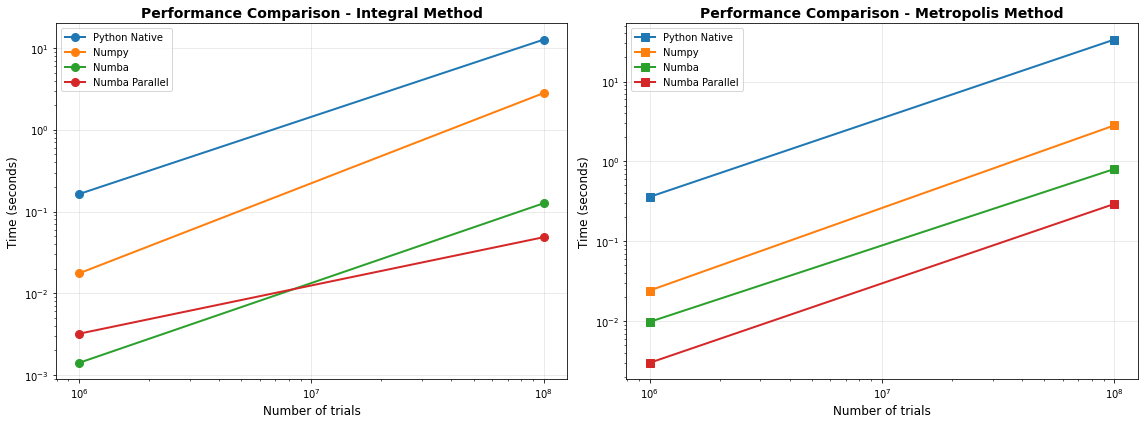

In [43]:
# Visualisation comparative - Méthode Intégrale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Méthode Intégrale
for name in implementations.keys():
    ax1.plot(NUM_TRIALS, benchmark_results[name]['integral'], 'o-', label=name, linewidth=2, markersize=8)

ax1.set_xlabel('Number of trials', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Performance Comparison - Integral Method', fontsize=14, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Graphique 2: Méthode Metropolis
for name in implementations.keys():
    ax2.plot(NUM_TRIALS, benchmark_results[name]['metropolis'], 's-', label=name, linewidth=2, markersize=8)

ax2.set_xlabel('Number of trials', fontsize=12)
ax2.set_ylabel('Time (seconds)', fontsize=12)
ax2.set_title('Performance Comparison - Metropolis Method', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [45]:
# Calcul et affichage du speedup
print("\n Speedup vs Python Native:")

baseline_integral = benchmark_results['Python Native']['integral']
baseline_metropolis = benchmark_results['Python Native']['metropolis']

for i, num_trial in enumerate(NUM_TRIALS):
    print(f"\n{num_trial:,} itérations:")
    
    for name in implementations.keys():
        if name != 'Python Native':
            speedup_integral = baseline_integral[i] / benchmark_results[name]['integral'][i]
            speedup_metropolis = baseline_metropolis[i] / benchmark_results[name]['metropolis'][i]
            print(f"  {name}:")
            print(f"    Integral: {speedup_integral:.1f}x plus rapide")
            print(f"    Metropolis: {speedup_metropolis:.1f}x plus rapide")


 Speedup vs Python Native:

1,000,000 itérations:
  Numpy:
    Integral: 9.3x plus rapide
    Metropolis: 14.9x plus rapide
  Numba:
    Integral: 116.1x plus rapide
    Metropolis: 36.7x plus rapide
  Numba Parallel:
    Integral: 51.1x plus rapide
    Metropolis: 119.3x plus rapide

100,000,000 itérations:
  Numpy:
    Integral: 4.5x plus rapide
    Metropolis: 11.9x plus rapide
  Numba:
    Integral: 100.4x plus rapide
    Metropolis: 41.6x plus rapide
  Numba Parallel:
    Integral: 261.3x plus rapide
    Metropolis: 114.0x plus rapide


## Analyse des performances

Les résultats montrent clairement que **Numba est le meilleur choix** pour optimiser le calcul de pi. Numba JIT offre des gains de **100-116x** pour l'intégrale et **37-42x** pour Metropolis, ce qui est largement supérieur à Numpy (5-15x). Numba Parallel va encore plus loin avec des accélérations de **51-261x** grâce à l'utilisation de plusieurs cœurs CPU. L'avantage de Numba est sa simplicité. En effet, il suffit d'ajouter `@njit` ou `@njit(parallel=True)` au code Python existant, sans avoir à réécrire le code en C comme Cython ou à vectoriser comme Numpy. Pour ce type de calcul avec des boucles intensives, Numba combine performance maximale et facilité d'utilisation, ce qui en fait la solution idéale.

Ce TP montre clairement le gain en performance et en temps lorsqu'on parallélise le code et l'exécutant sur différents coeurs CPU en même temps.